# Feature Engineering

## Cargue de librerias y parametros

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Agrega la ruta del directorio 'src' al path
sys.path.append(os.path.abspath('../src'))

# Ahora puedes importar tus módulos
from procesamiento_datos import *

Función de procesamiento de datos cargadas correctamente.


In [3]:
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
datos_raw = "..//data/raw/"
datos_processed = "..//data/processed/"

## Cargue de los dataframes

In [ ]:
# Definir la ruta a la carpeta 'data/raw'
datos_raw = "..//data/raw/"

# Cargar los datos
df_facturas = cargar_datos(datos_raw + "Historico_Facturas.csv")
df_cierres = cargar_datos(datos_raw + "Historico_Cierres.csv")
df_negocios = cargar_datos(datos_raw + "Tipos_Negocio.csv")
df_ipc = cargar_datos(datos_raw + "Historico_IPC.csv", sep=';')
df_tasas = cargar_datos(datos_raw + "Historico_Tasas_Credito.csv", sep=';')
df_pib = cargar_datos(datos_raw + "Historico_PIB_Corriente_Desc.csv")
df_sml = cargar_datos(datos_raw + "Historico_Salario_Minimo.csv")
df_clientes = cargar_datos(datos_raw + "Clientes_EEFF"

## Creación de features

In [14]:
fecha_referencia = pd.to_datetime('2025-06-30')

def calcular_dias_demora(row):
    if row ['estado'] == 'PAGADA' and row ['fecha_pago'] != 'NaT':
        return ( row['fecha_pago'] - row['fecha_vencimiento']).days
    else:
        return ( fecha_referencia - row['fecha_vencimiento']).days

df_facturas ['dias_demora'] = df_facturas.apply(calcular_dias_demora, axis=1)

In [15]:
#si los días de mora son negativos o iguales a 0 el habito de pago es bueno = 1 , si son mayores a 0 el habito de pago es malo = 0 
df_facturas['habito_pago'] = df_facturas['dias_demora'].apply(lambda x: 1 if x <= 0 else 0)

In [16]:
df_facturas

,id_cliente,numero_factura,fecha_expedicion,estado,total_factura,saldo,fecha_pago,fecha_vencimiento,valor_pagado,dias_demora,habito_pago
0,42ee24fec8333f54a4615265bb3b91ce3300fdf90ed8c8...,186537,2025-06-18,CONFIRMADA,1035398.0,1035398.0,NaT,2025-07-18,0.0,-18,1
1,46f8499a6c67d365a9242127ab7baf8a4e6505f2d4a4a4...,177214,2024-08-28,PAGADA,773500.0,0.0,2024-09-25,2024-09-27,773500.0,-2,1
2,727ed2c81ecbb468b0239c55c137ebc8515e8977eaf5ca...,161840,2022-11-25,PAGADA,11900000.0,0.0,2024-11-28,2022-12-25,11900000.0,704,0
3,c1dad0801a0cf886e273e08c58becbde2fee81c39b7168...,161841,2022-11-25,PAGADA,11900000.0,0.0,2024-08-07,2022-12-25,11900000.0,591,0
4,bec32d6c8b8f837ddb1545d7637586ca649e56d895c1ed...,177216,2024-08-28,PAGADA,773500.0,0.0,2025-01-10,2024-09-27,773500.0,105,0
...,...,...,...,...,...,...,...,...,...,...,...
61388,97b31466918fd7e03c16a066ce401222e419af2be7a68f...,181279,2025-02-13,PAGADA,41562106.0,0.0,2025-06-09,2025-03-15,41562106.0,86,0
61389,97b31466918fd7e03c16a066ce401222e419af2be7a68f...,184044,2025-03-06,PAGADA,43257302.0,0.0,2025-03-20,2025-04-05,43257302.0,-16,1
61390,97b31466918fd7e03c16a066ce401222e419af2be7a68f...,185064,2025-04-14,PAGADA,45900437.0,0.0,2025-04-16,2025-05-14,45900437.0,-28,1
61391,97b31466918fd7e03c16a066ce401222e419af2be7a68f...,185619,2025-05-09,PAGADA,45269411.0,0.0,2025-06-23,2025-06-08,45269411.0,15,0


In [17]:
print("Estadísticas de días de demora por estado:")
for estado in df_facturas['estado'].unique():
    subset = df_facturas[df_facturas['estado'] == estado]['dias_demora']
    print(f"\n{estado}:")
    print(f"  Count: {subset.count()}")
    print(f"  Mean: {subset.mean():.1f}")
    print(f"  Median: {subset.median():.1f}")
    print(f"  Max: {subset.max()}")

Estadísticas de días de demora por estado:

CONFIRMADA:
  Count: 786
  Mean: 70.2
  Median: 16.0
  Max: 1662

PAGADA:
  Count: 60546
  Mean: 647.1
  Median: 476.0
  Max: 2696

AMORTIZADA:
  Count: 61
  Mean: 163.8
  Median: 50.0
  Max: 1690


<Axes: xlabel='habito_pago'>

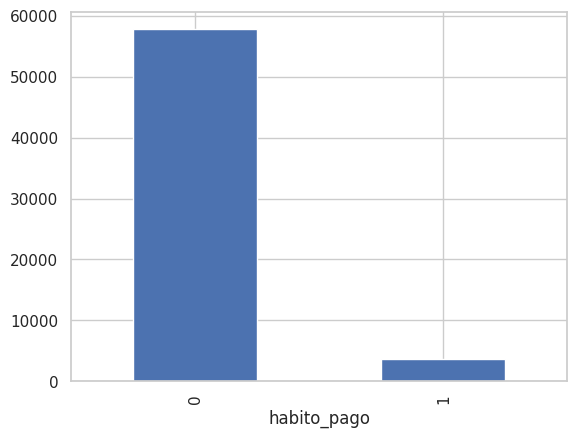

In [18]:
df_facturas['habito_pago'].value_counts().plot.bar()

In [19]:
df_prueba = df_cierres.merge(df_negocios, left_on='id_negocio', right_on='cod_negocio', how='left')
df_prueba

,fecha_cierre,id_cliente,dias_mora,calificacion,cuenta_cobrar,deterioro,id_negocio,cod_negocio,id_linea,nombre_linea
0,2023-01-31,bda703a41ee55dcb911f17164009bc87636552bd5a641b...,0,A,2380000.0,5236.0,b527ab75d12cba5a48db8e39b6dc776fafe8d0a64454c1...,b527ab75d12cba5a48db8e39b6dc776fafe8d0a64454c1...,2.0,Inmobiliario
1,2023-01-31,a6fbe7c3a37fa63f96d9ac3efe825deafc3c3d68ec13fe...,0,A,0.0,0.0,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,99.0,Otros
2,2023-01-31,f81197f9f4a967d97235421ba58bbe1e28c3a5eaf0efec...,0,A,0.0,0.0,eaab7f29f0ebeeb28a5fcae7dba2f7b07bf2fa942bab4b...,eaab7f29f0ebeeb28a5fcae7dba2f7b07bf2fa942bab4b...,3.0,Administración
3,2023-01-31,c8ade62397784043d77a93a6884460c5d86843a81f9c26...,0,A,0.0,0.0,aa6df8861c8ad85418960d463c1bfff2ec9d257d58e5ab...,aa6df8861c8ad85418960d463c1bfff2ec9d257d58e5ab...,9.0,Fondos de inversión colectiva
4,2023-01-31,22a725be4cbf11a95514f3c8e93885502034dfc44b52a2...,0,A,0.0,0.0,22a725be4cbf11a95514f3c8e93885502034dfc44b52a2...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
13112,2025-06-30,93c7f33267a36b3830bb2af33b99623fc6471effa12977...,561,E,36421600.0,36421600.0,79c34e61bb9da63b9bb88d87c02a531d8af9ed16d85c22...,79c34e61bb9da63b9bb88d87c02a531d8af9ed16d85c22...,2.0,Inmobiliario
13113,2025-06-30,56b789dc96acbcaa088edaf0439c0a901f961905680675...,466,E,49906220.0,49906220.0,136a27f6f0fd70909720b12ee3519e5aaedfbbfbbce1da...,136a27f6f0fd70909720b12ee3519e5aaedfbbfbbce1da...,4.0,Garantía
13114,2025-06-30,f495b5a0005d360b2a2c3e358b2d7973c0b3e7a76e371d...,962,E,13042400.0,13042400.0,8005c981fac40b3ab78dc2d9271bed69f4f8b9d1e18686...,8005c981fac40b3ab78dc2d9271bed69f4f8b9d1e18686...,4.0,Garantía
13115,2025-06-30,fbbabd04e6dd67e5db8b9bb554145338c77d7415d5f620...,1689,E,238394336.0,238394336.0,9ac073a07be208df6fa2ee0e4ce2a1e66c3e7156772228...,9ac073a07be208df6fa2ee0e4ce2a1e66c3e7156772228...,2.0,Inmobiliario


In [20]:
df_prueba = df_prueba.merge(df_clientes, left_on='id_cliente', right_on='id_hash', how='left')
df_prueba

,fecha_cierre,id_cliente,dias_mora,calificacion,cuenta_cobrar,deterioro,id_negocio,cod_negocio,id_linea,nombre_linea,codigo_camara,codigo_clase_identificacion,clase_identificacion,cod_ciiu_act_econ_pri,categoria_matricula,id_hash,presente_en_facturas,presente_en_cierres
0,2023-01-31,bda703a41ee55dcb911f17164009bc87636552bd5a641b...,0,A,2380000.0,5236.0,b527ab75d12cba5a48db8e39b6dc776fafe8d0a64454c1...,b527ab75d12cba5a48db8e39b6dc776fafe8d0a64454c1...,2.0,Inmobiliario,55.0,2.0,NIT,7490,SOCIEDAD ó PERSONA JURIDICA PRINCIPAL ó ESAL,bda703a41ee55dcb911f17164009bc87636552bd5a641b...,True,True
1,2023-01-31,bda703a41ee55dcb911f17164009bc87636552bd5a641b...,0,A,2380000.0,5236.0,b527ab75d12cba5a48db8e39b6dc776fafe8d0a64454c1...,b527ab75d12cba5a48db8e39b6dc776fafe8d0a64454c1...,2.0,Inmobiliario,21.0,2.0,NIT,7490,SOCIEDAD ó PERSONA JURIDICA PRINCIPAL ó ESAL,bda703a41ee55dcb911f17164009bc87636552bd5a641b...,True,True
2,2023-01-31,a6fbe7c3a37fa63f96d9ac3efe825deafc3c3d68ec13fe...,0,A,0.0,0.0,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,99.0,Otros,4.0,2.0,NIT,6612,SOCIEDAD ó PERSONA JURIDICA PRINCIPAL ó ESAL,a6fbe7c3a37fa63f96d9ac3efe825deafc3c3d68ec13fe...,True,True
3,2023-01-31,a6fbe7c3a37fa63f96d9ac3efe825deafc3c3d68ec13fe...,0,A,0.0,0.0,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,99.0,Otros,8.0,2.0,NIT,J671300,SOCIEDAD ó PERSONA JURIDICA PRINCIPAL ó ESAL,a6fbe7c3a37fa63f96d9ac3efe825deafc3c3d68ec13fe...,True,True
4,2023-01-31,f81197f9f4a967d97235421ba58bbe1e28c3a5eaf0efec...,0,A,0.0,0.0,eaab7f29f0ebeeb28a5fcae7dba2f7b07bf2fa942bab4b...,eaab7f29f0ebeeb28a5fcae7dba2f7b07bf2fa942bab4b...,3.0,Administración,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15911,2025-06-30,93c7f33267a36b3830bb2af33b99623fc6471effa12977...,561,E,36421600.0,36421600.0,79c34e61bb9da63b9bb88d87c02a531d8af9ed16d85c22...,79c34e61bb9da63b9bb88d87c02a531d8af9ed16d85c22...,2.0,Inmobiliario,21.0,2.0,NIT,6810,SOCIEDAD ó PERSONA JURIDICA PRINCIPAL ó ESAL,93c7f33267a36b3830bb2af33b99623fc6471effa12977...,True,True
15912,2025-06-30,56b789dc96acbcaa088edaf0439c0a901f961905680675...,466,E,49906220.0,49906220.0,136a27f6f0fd70909720b12ee3519e5aaedfbbfbbce1da...,136a27f6f0fd70909720b12ee3519e5aaedfbbfbbce1da...,4.0,Garantía,5.0,2.0,NIT,4111,SOCIEDAD ó PERSONA JURIDICA PRINCIPAL ó ESAL,56b789dc96acbcaa088edaf0439c0a901f961905680675...,True,True
15913,2025-06-30,f495b5a0005d360b2a2c3e358b2d7973c0b3e7a76e371d...,962,E,13042400.0,13042400.0,8005c981fac40b3ab78dc2d9271bed69f4f8b9d1e18686...,8005c981fac40b3ab78dc2d9271bed69f4f8b9d1e18686...,4.0,Garantía,8.0,2.0,NIT,6311,SOCIEDAD ó PERSONA JURIDICA PRINCIPAL ó ESAL,f495b5a0005d360b2a2c3e358b2d7973c0b3e7a76e371d...,True,True
15914,2025-06-30,fbbabd04e6dd67e5db8b9bb554145338c77d7415d5f620...,1689,E,238394336.0,238394336.0,9ac073a07be208df6fa2ee0e4ce2a1e66c3e7156772228...,9ac073a07be208df6fa2ee0e4ce2a1e66c3e7156772228...,2.0,Inmobiliario,4.0,2.0,NIT,4111,SOCIEDAD ó PERSONA JURIDICA PRINCIPAL ó ESAL,fbbabd04e6dd67e5db8b9bb554145338c77d7415d5f620...,True,True


In [21]:
# Crear indicadores por cliente
indicadores_cliente = pd.DataFrame()

# 1. Promedio de días de mora
dias_mora_promedio = df_facturas.groupby('id_cliente')['dias_demora'].mean()
indicadores_cliente['promedio_dias_mora'] = dias_mora_promedio

# 2. Porcentaje de facturas pagadas a tiempo
habitos_pago = df_facturas.groupby('id_cliente')['habito_pago'].agg(['mean', 'count'])
indicadores_cliente['porcentaje_pagos_tiempo'] = habitos_pago['mean'] * 100
indicadores_cliente['total_facturas'] = habitos_pago['count']

# 3. Monto promedio de facturas
monto_promedio = df_facturas.groupby('id_cliente')['total_factura'].mean()
indicadores_cliente['monto_promedio_facturas'] = monto_promedio

# 4. Ratio de pago (valor_pagado/total_factura)
df_facturas['ratio_pago'] = df_facturas['valor_pagado'] / df_facturas['total_factura']
ratio_pago_promedio = df_facturas.groupby('id_cliente')['ratio_pago'].mean()
indicadores_cliente['ratio_pago_promedio'] = ratio_pago_promedio

# 5. Desviación estándar de días de mora (volatilidad en pagos)
desv_dias_mora = df_facturas.groupby('id_cliente')['dias_demora'].std()
indicadores_cliente['volatilidad_dias_mora'] = desv_dias_mora

# 6. Máximo de días de mora histórico
max_dias_mora = df_facturas.groupby('id_cliente')['dias_demora'].max()
indicadores_cliente['maximo_dias_mora'] = max_dias_mora

# 7. Facturas vencidas actualmente
facturas_vencidas = df_facturas[df_facturas['estado'] != 'PAGADA'].groupby('id_cliente').size()
indicadores_cliente['facturas_vencidas_actuales'] = facturas_vencidas.fillna(0)

# 8. Monto total pendiente
saldo_pendiente = df_facturas[df_facturas['estado'] != 'PAGADA'].groupby('id_cliente')['saldo'].sum()
indicadores_cliente['saldo_pendiente_total'] = saldo_pendiente.fillna(0)

print("Resumen de indicadores calculados:")
print(indicadores_cliente.describe())

Resumen de indicadores calculados:
       promedio_dias_mora  porcentaje_pagos_tiempo  total_facturas  \
count         2927.000000              2927.000000     2927.000000   
mean           588.758972                 6.949679       20.974718   
std            470.208498                21.327177      106.255914   
min            -30.000000                 0.000000        1.000000   
25%            207.000000                 0.000000        1.000000   
50%            519.000000                 0.000000        1.000000   
75%            856.500000                 2.197802       13.000000   
max           2642.000000               100.000000     5093.000000   

       monto_promedio_facturas  ratio_pago_promedio  volatilidad_dias_mora  \
count             2.927000e+03          2927.000000            1164.000000   
mean              3.486871e+06             0.989338             433.963383   
std               5.362195e+07             0.078744             236.289757   
min               9.33

In [22]:
# Crear sistema de scoring
def calcular_score_credito(row):
    score = 0
    
    # 1. Porcentaje de pagos a tiempo (max 30 puntos)
    score += min(row['porcentaje_pagos_tiempo'] * 0.3, 30)
    
    # 2. Días de mora promedio (max 25 puntos)
    if row['promedio_dias_mora'] <= 0:
        score += 25
    elif row['promedio_dias_mora'] <= 30:
        score += 15
    elif row['promedio_dias_mora'] <= 60:
        score += 5
    
    # 3. Ratio de pago promedio (max 20 puntos)
    score += min(row['ratio_pago_promedio'] * 20, 20)
    
    # 4. Facturas vencidas actuales (max 15 puntos)
    if row['facturas_vencidas_actuales'] == 0:
        score += 15
    elif row['facturas_vencidas_actuales'] <= 2:
        score += 7
    
    # 5. Volatilidad en pagos (max 10 puntos)
    if pd.isna(row['volatilidad_dias_mora']) or row['volatilidad_dias_mora'] <= 15:
        score += 10
    elif row['volatilidad_dias_mora'] <= 30:
        score += 5
    
    return score

# Calcular el score para cada cliente
indicadores_cliente['score_credito'] = indicadores_cliente.apply(calcular_score_credito, axis=1)

# Establecer categorías de riesgo basadas en el score
def categorizar_riesgo(score):
    if score >= 85:
        return 'A - Riesgo Bajo'
    elif score >= 70:
        return 'B - Riesgo Moderado Bajo'
    elif score >= 50:
        return 'C - Riesgo Moderado'
    elif score >= 30:
        return 'D - Riesgo Moderado Alto'
    else:
        return 'E - Riesgo Alto'

indicadores_cliente['categoria_riesgo'] = indicadores_cliente['score_credito'].apply(categorizar_riesgo)

# Mostrar distribución de scores y categorías
print("\nDistribución de Scores de Crédito:")
print(indicadores_cliente['score_credito'].describe())

print("\nDistribución de Categorías de Riesgo:")
print(indicadores_cliente['categoria_riesgo'].value_counts())


Distribución de Scores de Crédito:
count    2927.000000
mean       30.229713
std        13.017618
min         6.875000
25%        21.723810
50%        30.000000
75%        30.000000
max        87.000000
Name: score_credito, dtype: float64

Distribución de Categorías de Riesgo:
categoria_riesgo
D - Riesgo Moderado Alto    1741
E - Riesgo Alto             1038
A - Riesgo Bajo              122
C - Riesgo Moderado           18
B - Riesgo Moderado Bajo       8
Name: count, dtype: int64


In [23]:
# Resetear el índice para tener id_cliente como columna
indicadores_cliente = indicadores_cliente.reset_index()

# Realizar el merge con df_prueba
df_final = df_prueba.merge(indicadores_cliente, 
                          left_on='id_cliente',
                          right_on='id_cliente',
                          how='left')

print("\nColumnas en el DataFrame final:")
print(df_final.columns.tolist())

print("\nDimensiones del DataFrame final:")
print(f"Filas: {df_final.shape[0]}, Columnas: {df_final.shape[1]}")

# Verificar si hay clientes sin score
clientes_sin_score = df_final[df_final['score_credito'].isna()]['id_cliente'].nunique()
print(f"\nClientes sin score de crédito: {clientes_sin_score}")

# Mostrar las primeras filas del DataFrame final con las columnas más relevantes
columnas_relevantes = ['id_cliente', 'fecha_cierre', 'cuenta_cobrar', 'dias_mora', 
                      'calificacion', 'score_credito', 'categoria_riesgo', 
                      'promedio_dias_mora', 'porcentaje_pagos_tiempo']

print("\nMuestra del DataFrame final con columnas relevantes:")
print(df_final[columnas_relevantes].head())


Columnas en el DataFrame final:
['fecha_cierre', 'id_cliente', 'dias_mora', 'calificacion', 'cuenta_cobrar', 'deterioro', 'id_negocio', 'cod_negocio', 'id_linea', 'nombre_linea', 'codigo_camara', 'codigo_clase_identificacion', 'clase_identificacion', 'cod_ciiu_act_econ_pri', 'categoria_matricula', 'id_hash', 'presente_en_facturas', 'presente_en_cierres', 'promedio_dias_mora', 'porcentaje_pagos_tiempo', 'total_facturas', 'monto_promedio_facturas', 'ratio_pago_promedio', 'volatilidad_dias_mora', 'maximo_dias_mora', 'facturas_vencidas_actuales', 'saldo_pendiente_total', 'score_credito', 'categoria_riesgo']

Dimensiones del DataFrame final:
Filas: 15916, Columnas: 29

Clientes sin score de crédito: 36

Muestra del DataFrame final con columnas relevantes:
                                          id_cliente fecha_cierre  \
0  bda703a41ee55dcb911f17164009bc87636552bd5a641b...   2023-01-31   
1  bda703a41ee55dcb911f17164009bc87636552bd5a641b...   2023-01-31   
2  a6fbe7c3a37fa63f96d9ac3efe82

## Incorporación de variables macroeconómicas
Agregaremos las variables macroeconómicas (IPC, PIB, tasas de crédito y salario mínimo) al DataFrame final. Estas variables son importantes para capturar el contexto económico en el que se desarrollan los comportamientos de pago.

In [24]:
def clean_data(df_sml):
    # Cambiar el nombre de la columna 'Serie' a 'Fecha'
    df_sml = df_sml.rename(columns={'Serie': 'Fecha'})
    # Cambiar el nombre de la columna 'Salario\xa0mínimo\xa0mensual' a 'SML'
    df_sml = df_sml.rename(columns={'Salario\xa0mínimo\xa0mensual': 'SML'})
    # Eliminar las columnas: 'Auxilio de transporte mensual', 'Salario mínimo mensual, sector rural', 'Salario mínimo mensual, sector urbano alto'
    df_sml = df_sml.drop(columns=['Auxilio\xa0de\xa0transporte\xa0mensual', 'Salario\xa0mínimo\xa0mensual,\xa0sector\xa0rural', 'Salario\xa0mínimo\xa0mensual,\xa0sector\xa0urbano\xa0alto'])
    return df_sml

df_sml = clean_data(df_sml.copy())
df_sml.head()

,Fecha,SML
0,1950-01-31,.
1,1950-02-28,.
2,1950-03-31,.
3,1950-04-30,.
4,1950-05-31,.


In [25]:
def clean_data(df_ipc):
    # Eliminar las columnas: 'Inflación sin alimentos ni regulados, anual', 'Inflación sin alimentos, anual'
    df_ipc = df_ipc.drop(columns=['Inflación\xa0sin\xa0alimentos\xa0ni\xa0regulados,\xa0anual', 'Inflación\xa0sin\xa0alimentos,\xa0anual'])
    # Cambiar el nombre de la columna 'Inflación\xa0núcleo\xa015 anual' a 'IPC'
    df_ipc = df_ipc.rename(columns={'Inflación\xa0núcleo\xa015 anual': 'IPC'})
    return df_ipc

df_ipc = clean_data(df_ipc.copy())
df_ipc.head()

,Fecha,IPC
0,31/01/1999,"16,47"
1,28/02/1999,"15,35"
2,31/03/1999,"13,92"
3,30/04/1999,"12,98"
4,31/05/1999,"12,12"


In [26]:
def clean_data(df_pib):
    # Eliminar las columnas: '1.01. Valor agregado bruto', '1.01.01. Agricultura, ganadería, caza, silvicultura y pesca' y 13 otras columnas
    df_pib = df_pib.drop(columns=['1.01. Valor agregado bruto', '1.01.01. Agricultura, ganadería, caza, silvicultura y pesca', '1.01.02. Explotación de minas y canteras', '1.01.03. Industrias manufactureras', '1.01.04. Suministro de electricidad, gas, vapor y\naire acondicionado (*)', '1.01.05. Construcción', '1.01.06. Comercio al por mayor y al por menor\n(*)', '1.01.07. Información y comunicaciones', '1.01.08. Actividades financieras y de seguros', '1.01.09. Actividades inmobiliarias', '1.01.10. Actividades profesionales, científicas y\ntécnicas (*)', '1.01.11. Administración pública, defensa,\neducación y salud (*)', '1.01.12. Actividades artísticas, de\nentretenimiento y recreación y otras actividades\nde servicios (*)', '1.02. Impuestos menos subvenciones sobre los\nproductos', '\xa0\nLos\xa0valores\xa0ausentes\xa0se\xa0indican\xa0con\xa0un\xa0punto\xa0(.)\nDescargado\xa0del\xa0sistema\xa0del\xa0Banco\xa0de\xa0la\xa0República:\xa008/08/2025\xa0\xa06:22:02\xa0PM'])
    # Cambiar el nombre de la columna '1. PIB reportado' a 'PIB'
    df_pib = df_pib.rename(columns={'1. PIB reportado': 'PIB'})
    return df_pib

df_pib = clean_data(df_pib.copy())
df_pib.head()

,Fecha,PIB
0,2005-01-31,"81365,11"
1,2005-02-28,"81365,11"
2,2005-03-31,"81365,11"
3,2005-04-30,"84193,31"
4,2005-05-31,"84193,31"


In [27]:
def clean_data(df_tasas):
    # Eliminar las columnas: 'Créditos de tesorería', 'Créditos ordinarios' y 4 otras columnas
    df_tasas = df_tasas.drop(columns=['Créditos\xa0de\xa0tesorería', 'Créditos\xa0ordinarios', 'Créditos\xa0preferenciales', 'Tasas\xa0de\xa0Colocación\xa0Banco\xa0de\xa0la\xa0República', 'Tasas\xa0de\xa0Colocación\xa0sin\xa0tesoreria', 'Tasas\xa0de\xa0Colocación\xa0total'])
    # Cambiar el nombre de la columna 'Créditos\xa0de\xa0consumo' a 'Tasa'
    df_tasas = df_tasas.rename(columns={'Créditos\xa0de\xa0consumo': 'Tasa'})
    return df_tasas

df_tasas = clean_data(df_tasas.copy())
df_tasas.head()

,Fecha,Tasa
0,31/03/1998,"42,24"
1,30/04/1998,"44,08"
2,31/05/1998,"45,32"
3,30/06/1998,"48,41"
4,31/07/1998,"51,57"


In [ ]:
# Preparar datos macroeconómicos
# IPC
df_ipc['Fecha'] = pd.to_datetime(df_ipc['Fecha'])
df_ipc = df_ipc.rename(columns={'Fecha': 'fecha_cierre', 'IPC': 'ipc'})
df_ipc['ipc'] = pd.to_numeric(df_ipc['ipc'], errors='coerce')

# PIB
df_pib['Fecha'] = pd.to_datetime(df_pib['Fecha'])
df_pib = df_pib.rename(columns={'Fecha': 'fecha_cierre', 'PIB': 'pib'})
df_pib['pib'] = pd.to_numeric(df_pib['pib'], errors='coerce')

# Tasas de crédito
df_tasas['Fecha'] = pd.to_datetime(df_tasas['Fecha'])
df_tasas = df_tasas.rename(columns={'Fecha': 'fecha_cierre', 'Tasa': 'tasa_credito'})
df_tasas['tasa_credito'] = pd.to_numeric(df_tasas['tasa_credito'], errors='coerce')

# Salario mínimo
df_sml['Fecha'] = pd.to_datetime(df_sml['Fecha'])
df_sml = df_sml.rename(columns={'Fecha': 'fecha_cierre', 'SML': 'salario_minimo'})
df_sml['salario_minimo'] = pd.to_numeric(df_sml['salario_minimo'], errors='coerce')

# Merge de todas las variables macroeconómicas con df_final
df_final = df_final.merge(df_ipc[['fecha_cierre', 'ipc']], on='fecha_cierre', how='left')
df_final = df_final.merge(df_pib[['fecha_cierre', 'pib']], on='fecha_cierre', how='left')
df_final = df_final.merge(df_tasas[['fecha_cierre', 'tasa_credito']], on='fecha_cierre', how='left')
df_final = df_final.merge(df_sml[['fecha_cierre', 'salario_minimo']], on='fecha_cierre', how='left')

In [34]:
# Verificar los tipos de datos de las columnas macroeconómicas
print("Tipos de datos de las columnas macroeconómicas:")
print("\nTipos de datos en df_ipc:")
print(df_ipc.dtypes)
print("\nPrimeras filas de df_ipc:")
print(df_ipc.head())

print("\nTipos de datos en df_final después del merge:")
print(df_final[['ipc', 'pib', 'tasa_credito', 'salario_minimo']].dtypes)
print("\nPrimeras filas de las variables macro en df_final:")
print(df_final[['ipc', 'pib', 'tasa_credito', 'salario_minimo']].head())

Tipos de datos de las columnas macroeconómicas:

Tipos de datos en df_ipc:
fecha_cierre    datetime64[ns]
ipc                     object
dtype: object

Primeras filas de df_ipc:
  fecha_cierre    ipc
0   1999-01-31  16,47
1   1999-02-28  15,35
2   1999-03-31  13,92
3   1999-04-30  12,98
4   1999-05-31  12,12

Tipos de datos en df_final después del merge:
ipc               object
pib               object
tasa_credito      object
salario_minimo    object
dtype: object

Primeras filas de las variables macro en df_final:
     ipc        pib tasa_credito salario_minimo
0  11,84  394716,61        30,84   1.160.000,00
1  11,84  394716,61        30,84   1.160.000,00
2  11,84  394716,61        30,84   1.160.000,00
3  11,84  394716,61        30,84   1.160.000,00
4  11,84  394716,61        30,84   1.160.000,00


In [42]:
# Calcular variaciones mensuales de las variables macroeconómicas
# Asegurar que las columnas sean numéricas
for col in ['ipc', 'pib', 'tasa_credito', 'salario_minimo']:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce')

# Ordenar por fecha para asegurar el cálculo correcto de las variaciones
df_final = df_final.sort_values('fecha_cierre')

# Calcular las variaciones mensuales (respecto al mes anterior)
df_final['var_ipc'] = df_final['ipc'].pct_change(periods=1) * 100
df_final['var_pib'] = df_final['pib'].pct_change(periods=1) * 100
df_final['var_tasa_credito'] = df_final['tasa_credito'].pct_change(periods=1) * 100
df_final['var_salario_minimo'] = df_final['salario_minimo'].pct_change(periods=1) * 100

# Volver a ordenar por cliente y fecha para mantener la consistencia
df_final = df_final.sort_values(['id_cliente', 'fecha_cierre'])

In [43]:
# Verificar las variables macroeconómicas y sus variaciones mensuales
print("Resumen de variables macroeconómicas:")
columnas_macro = ['ipc', 'pib', 'tasa_credito', 'salario_minimo', 
                  'var_ipc', 'var_pib', 'var_tasa_credito', 'var_salario_minimo']

# Mostrar estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(df_final[columnas_macro].describe())

# Mostrar algunos valores ejemplo ordenados por fecha
print("\nEjemplos de valores y variaciones mensuales (ordenados por fecha):")
print("\nNota: Las variaciones son respecto al mes anterior")
df_ejemplo = df_final[['fecha_cierre'] + columnas_macro].sort_values('fecha_cierre').head(24)
print(df_ejemplo.to_string())

Resumen de variables macroeconómicas:

Estadísticas descriptivas:
       ipc  pib  tasa_credito  salario_minimo  var_ipc  var_pib  \
count  0.0  0.0           0.0             0.0      0.0      0.0   
mean   NaN  NaN           NaN             NaN      NaN      NaN   
std    NaN  NaN           NaN             NaN      NaN      NaN   
min    NaN  NaN           NaN             NaN      NaN      NaN   
25%    NaN  NaN           NaN             NaN      NaN      NaN   
50%    NaN  NaN           NaN             NaN      NaN      NaN   
75%    NaN  NaN           NaN             NaN      NaN      NaN   
max    NaN  NaN           NaN             NaN      NaN      NaN   

       var_tasa_credito  var_salario_minimo  
count               0.0                 0.0  
mean                NaN                 NaN  
std                 NaN                 NaN  
min                 NaN                 NaN  
25%                 NaN                 NaN  
50%                 NaN                 NaN  
75%     

## Definición de la variable objetivo (Default)
Crearemos la variable objetivo basada en dos criterios:
1. Días de mora > 90 días
2. Calificación crediticia (D o E)

In [44]:
# Definir default basado en días de mora y calificación
df_final['default'] = ((df_final['dias_mora'] > 90) | 
                      (df_final['calificacion'].isin(['D', 'E']))).astype(int)

# Calcular la tasa de default
tasa_default = df_final['default'].mean() * 100

print(f"Tasa de default en la cartera: {tasa_default:.2f}%")

# Mostrar distribución de defaults por categoría de riesgo
print("\nDistribución de defaults por categoría de riesgo:")
print(pd.crosstab(df_final['categoria_riesgo'], df_final['default'], 
                  normalize='index') * 100)

# Guardar el DataFrame final procesado
df_final.to_csv('../data/processed/datos_modelado.csv', index=False)
print("\nDataset guardado en '../data/processed/datos_modelado.csv'")

Tasa de default en la cartera: 12.32%

Distribución de defaults por categoría de riesgo:
default                            0          1
categoria_riesgo                               
A - Riesgo Bajo           100.000000   0.000000
B - Riesgo Moderado Bajo  100.000000   0.000000
C - Riesgo Moderado       100.000000   0.000000
D - Riesgo Moderado Alto   98.206495   1.793505
E - Riesgo Alto            85.937843  14.062157

Dataset guardado en '../data/processed/datos_modelado.csv'

Dataset guardado en '../data/processed/datos_modelado.csv'


In [45]:
df_final

,fecha_cierre,id_cliente,dias_mora,calificacion,cuenta_cobrar,deterioro,id_negocio,cod_negocio,id_linea,nombre_linea,...,categoria_riesgo,ipc,pib,tasa_credito,salario_minimo,default,var_ipc,var_pib,var_tasa_credito,var_salario_minimo
8476,2024-04-30,023c07084a0d5940f2de0e11ff05fbc8f2077d085144c0...,0,A,7.735000e+05,1.701700e+04,77c9010f2baaf521cdd124557fc731fcabee2ddd240fd5...,77c9010f2baaf521cdd124557fc731fcabee2ddd240fd5...,2.0,Inmobiliario,...,A - Riesgo Bajo,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
9049,2024-05-31,023c07084a0d5940f2de0e11ff05fbc8f2077d085144c0...,0,A,0.000000e+00,0.000000e+00,77c9010f2baaf521cdd124557fc731fcabee2ddd240fd5...,77c9010f2baaf521cdd124557fc731fcabee2ddd240fd5...,2.0,Inmobiliario,...,A - Riesgo Bajo,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
3588,2023-07-31,0265ed262c8b358431e8233e6de623825fb5827ac49a90...,0,A,6.429008e+09,1.414382e+09,0265ed262c8b358431e8233e6de623825fb5827ac49a90...,0265ed262c8b358431e8233e6de623825fb5827ac49a90...,3.0,Administración,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
4258,2023-08-31,027746ade127f44a65f74b3a169c981b097da9e125d513...,0,A,6.902000e+05,1.518440e+05,423bfa8170845487fc09a3d2111e50b6f30b517dd998d2...,423bfa8170845487fc09a3d2111e50b6f30b517dd998d2...,2.0,Inmobiliario,...,D - Riesgo Moderado Alto,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
4883,2023-09-30,027746ade127f44a65f74b3a169c981b097da9e125d513...,0,A,0.000000e+00,0.000000e+00,423bfa8170845487fc09a3d2111e50b6f30b517dd998d2...,423bfa8170845487fc09a3d2111e50b6f30b517dd998d2...,2.0,Inmobiliario,...,D - Riesgo Moderado Alto,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12274,2024-11-30,ff77d1fd01ee1f5d70c79693d6ac9bf781d0f4cce978e8...,26,A,9.282000e+06,2.042040e+05,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,99.0,Otros,...,E - Riesgo Alto,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
12770,2024-12-31,ff77d1fd01ee1f5d70c79693d6ac9bf781d0f4cce978e8...,57,B,1.392300e+07,5.290740e+05,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,99.0,Otros,...,E - Riesgo Alto,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
13109,2025-01-31,ff77d1fd01ee1f5d70c79693d6ac9bf781d0f4cce978e8...,0,A,0.000000e+00,0.000000e+00,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,99.0,Otros,...,E - Riesgo Alto,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
11028,2024-09-30,ff80bb5730abd30c3495ddc72d3f710674294a348a486f...,0,A,1.190000e+07,2.618000e+04,5e5faf72f089c72f90e5ec4b3896b95545495ec7cfd9e3...,5e5faf72f089c72f90e5ec4b3896b95545495ec7cfd9e3...,4.0,Garantía,...,A - Riesgo Bajo,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
